# 05 SEMM

System equivalent model mixing (SEMM) is a method based on Frequency Based Substructuring (FBS) and enables the construction of hybrid dynamic models by combining numerical and experimental models.

In [1]:
import pyFBS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data import

Importing of example data: 
 - 3D model in stl format
 - locations and directions of responses and impacts in xlsx format
 - Ansys .full file
 - Ansys .res file
 - experimentally obtained FRFs stored in a pickle file

In [2]:
# pyFBS.download_lab_testbench()

In [3]:
stl = r"./lab_testbench/STL/AB.stl"
xlsx = r"./lab_testbench/Measurements/AM_measurements.xlsx"

full_file = r"./lab_testbench/FEM/AB.full"
rst_file = r"./lab_testbench/FEM/AB.rst"

exp_file = r"./lab_testbench/Measurements/Y_AB.p"

### Experimental data import

In [4]:
freq, Y_AB_exp = np.load(exp_file, allow_pickle = True)

# Numerical model

In this showcase, a numerical model of the admittance matrix will be generated using the mode superposition method which is included in the pyFBS library.

In [5]:
MK = pyFBS.MK_model(rst_file,full_file,no_modes = 100,recalculate = False)

### Show 3D model

In [6]:
view3D = pyFBS.display.view3D(show_origin= True)

In [7]:
view3D.add_stl(stl,name = "engine_mount",color = "#8FB1CC",opacity = .1);

In [8]:
view3D.plot.add_mesh(MK.mesh, scalars = np.ones(MK.mesh.points.shape[0]) ,name = "mesh",cmap = "coolwarm", show_edges = True);

##### Import and show impact locations

In [9]:
df_imp = pd.read_excel(xlsx, sheet_name='Impacts_AB')
view3D.show_imp(df_imp)
# view3D.label_imp(df_imp)
# df_imp

##### Import and show response locations

In [10]:
df_acc = pd.read_excel(xlsx, sheet_name='Sensors_B')
view3D.show_acc(df_acc,overwrite = True)
#view3D.label_imp(df_imp)
#df_imp

In [11]:
df_chn = pd.read_excel(xlsx, sheet_name='Channels_AB')
view3D.show_chn(df_chn)
# view3D.label_chn(df_chn)
# df_chn

##### Updated locations of responses and impacts to where nodes actually exist

In [12]:
df_chn_up = MK.update_locations_df(df_chn)
df_imp_up = MK.update_locations_df(df_imp)

In [13]:
# view3D.show_chn(df_chn_up, color = "k",overwrite = False)
# view3D.show_imp(df_imp_up, color = "k",overwrite = False)

### FRFs synthetization

For the SEMM method, the numerical model should include at least those DoFs that are also included in the experimental model, but additional other DoFs may also be included. In the presented case, the numerical admittance matrix will be generated only for locations where measurements were made. 

In [14]:
MK.FRF_synth(df_chn,df_imp, 
             f_start=0,
             f_end=2002.5,
             f_resolution=2.5,
             modal_damping = 0.003,
             frf_type = "accelerance")

# SEMM

The correct formation of the numerical and the experimental model is crucial for the correct operation of the SEMM method.

The first dimension of both matrices must represent frequency depth, second locations of responses, and third locations of excitations. 

### Numerical model

Locations of responses in the numerical model (order of rows) must be synchronized with the order of locations in ``df_chn_num`` DataFrame. The same must be valid also for impact locations in the numerical model (order of columns), which must be synchronized with the order of locations in ``df_imp_num`` DataFrame. 

In [15]:
Y_num = MK.FRF

df_chn_num = df_chn
df_imp_num = df_imp

### Experimental model

Locations of responses in the experimental model (order of rows) must be synchronized with the order of locations in ``df_chn_exp`` DataFrame. The same must be valid also for impact locations in the experimental model (order of columns), which must be synchronized with the order of locations in ``df_imp_exp`` DataFrame.

In this case, only the responses at locations between 0 and 15 and the excitations at locations between 5 and 20 were intentionally included in the experimental model, to show the applicability of the SEMM method.

In [16]:
Y_exp = np.transpose(Y_AB_exp[0:15, 5:20, :], (2, 0, 1))

df_chn_exp = df_chn[0:15]
df_imp_exp = df_imp[5:20]

### Implementation of SEMM

The SEMM method can be implemented in three different ways, which is set with the ``SEMM_type`` parameter:

 - In the ``basic`` formulation of the SEMM method, the removed model includes only those DoFs that are also included in the experimental (overlay) model, which can cause spurious peaks in the obtained frequency transfer functions.

 - In the ``fully-extend`` formulation of the SEMM method, the removed model is extended to all DoFs, which removes spurious peaks in resulting FRFs. 

 - The  ``fully-extend-svd`` formulation also includes SVD decomposition, where the eigenvalues are filtered while taking into account compatibility and equilibrium conditions. How many lowest natural frequencies will be omitted for each condition is defined with the parameters ``red_comp`` and ``red_eq``.

In [17]:
Y_num_SEMM = pyFBS.SEMM(Y_num, Y_exp, 
                        df_chn_num, 
                        df_imp_num, 
                        df_chn_exp, 
                        df_imp_exp, 
                        SEMM_type='fully-extend-svd', 
                        red_comp=10, red_eq=10)

# FRF visualisation

The results are shown at the location (24, 24) for which experimental measurements were not included in the SEMM. Therefore, at this point, we can compare how well SEMM extended the dynamic properties of the experimental model to the other DoFs included in the numerical model, compared to the measurement that was actually performed on the structure.

,Name,Quantity,Position_1,Position_2,Position_3,Direction_1,Direction_2,Direction_3
24,S9 X,Acceleration,315.196534,207.024374,20.318070,0.0,0.0,1.0
24,I25,Force,306.717813,255.034685,27.000001,0.0,0.0,-1.0


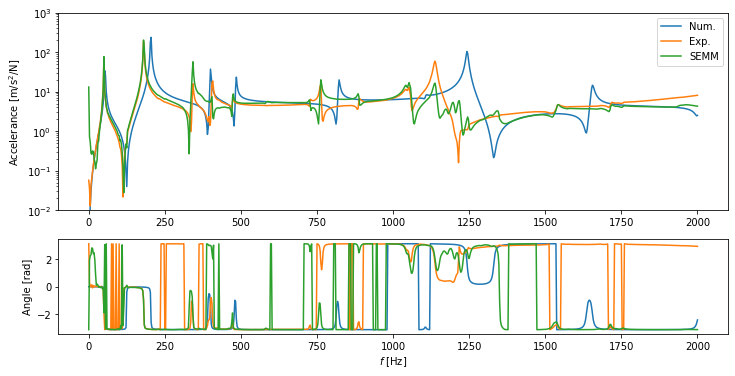

In [18]:
s1 = 24
s2 = 24

param = ["Name", "Quantity","Position_1", "Position_2", "Position_3", "Direction_1", "Direction_2", "Direction_3"]

df_disp = df_chn.iloc[[s1]][param].copy()
display(df_disp.append(df_imp.iloc[[s2]][param]))

plt.figure(figsize = (12,8))

plt.subplot(211)
plt.ylim(10**-2, 10**3)
plt.semilogy(MK.freq,np.abs(MK.FRF[:,s1,s2]), label = "Num.")
plt.semilogy(freq,np.abs(Y_AB_exp[s1,s2]), label = "Exp.")
plt.semilogy(freq,np.abs(Y_num_SEMM[:, s1,s2]), label = "SEMM")
plt.ylabel("Accelerance [m/s$^2$/N]")
plt.legend()

plt.subplot(413)
plt.plot(MK.freq,np.angle(MK.FRF[:,s1,s2]))
plt.plot(freq,np.angle(Y_AB_exp[s1,s2]))
plt.plot(MK.freq,np.angle(Y_num_SEMM[:,s1,s2]))
plt.xlabel("$f$ [Hz]")
plt.ylabel("Angle [rad]");